# Trabajo Práctico Nº4 Identificación de sistemas mediante modelos lineales: Uso de Correlación


##Instalación de librerías necesarias e importanción de las mismas

In [ ]:
!pip install -U control qtpy;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import control as ctrl
from control.matlab import *
import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt

## Generación de la señal PRBS

In [161]:
# Generación de la señal PRBS
m = 15 #Cambiar a 7 o a 15 según corresponda
x = np.zeros(m + 1)
x[1] = 1  # Ajuste de índices (Python comienza en 0)
x[3] = 1
x[5] = 1
N = 5000  # Puntos de la PRBS
el = 5
y = np.zeros(N)
for k in range(0, N, el):
    for h in range(m-1, -1, -1):
        x[h+1] = x[h]
    x[0] = np.bitwise_xor(int(x[1]), int(x[-1]))
    y[k:k+el] = x[m]

x = 2 * y[:N] - 1  # Escalar señal a {-1, 1}
np.random.seed(0) # Fijar la semilla para reproducibilidad
#x = np.sqrt(1) * np.random.randn(N) #Señal aleatoria, ruido blanco
vmed= np.mean(x)
varianza= np.var(x)
print(vmed)
print(varianza)

-0.07
0.9950999999999999


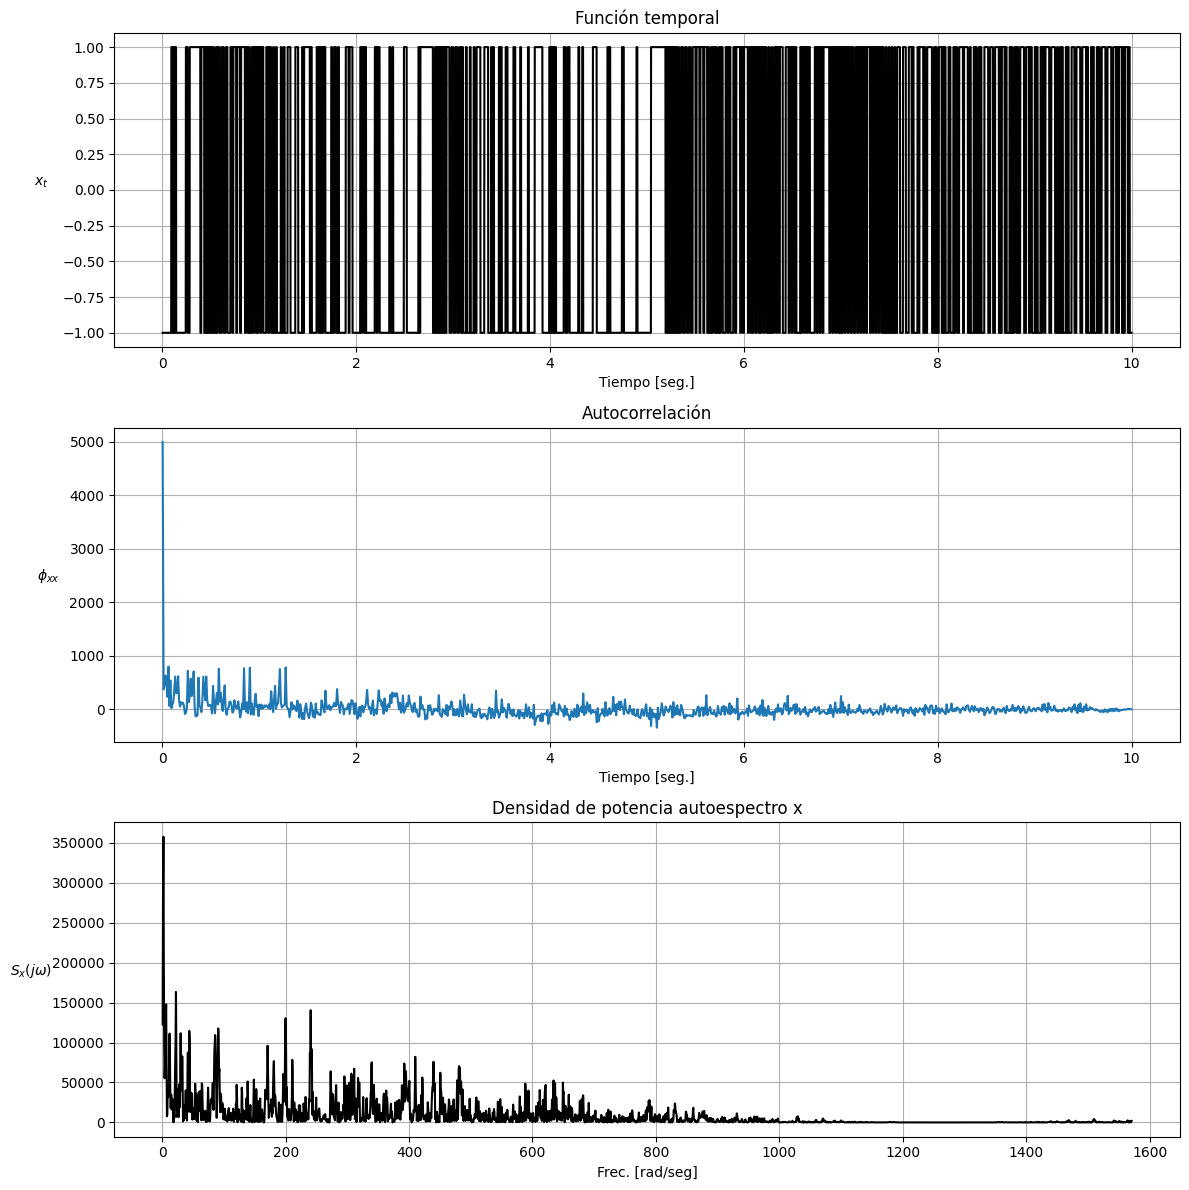

0.10101010101010101


In [163]:
# Cálculo de correlaciones
At = 1/500  # Tasa de muestreo
fs = 1/At   # Frecuencia de muestreo
Tmax = N * At
t = np.arange(At, Tmax + At, At)
fmax = fs / 2
Af = fmax / (0.5 * N)
w1 = np.arange(0, fmax, Af)

# Autocorrelación de x
fixxM = signal.correlate(x, x, mode='full')

# Cálculo de la densidad de potencia espectral
M1 = int(0.99 * N)
j1 = np.arange(M1)

Sx = fft.fft(fixxM)
Af = 2 * fmax / M1
w0 = 2 * np.pi * np.arange(Af, fmax + Af, Af)

# Gráficos de autocorrelación y espectro
with plt.style.context('ieee'):
  plt.figure(2, figsize=(12, 12), dpi=100)
plt.subplot(3, 1, 1)
plt.grid(True)
plt.plot(t, x, '-k')
plt.title('Función temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('$x_t$', rotation=0, labelpad=15)

plt.subplot(3, 1, 2)
plt.grid(True)
plt.plot(t, fixxM[N-1:2*N-1])
plt.title('Autocorrelación')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('$\phi_{xx}$', rotation=0, labelpad=15)

plt.subplot(3, 1, 3)
plt.grid(True)
plt.plot(w0[:M1//2], np.abs(Sx[:M1//2]), 'k')
plt.title('Densidad de potencia autoespectro x')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel('$S_x(j\omega)$', rotation=0, labelpad=15)
plt.tight_layout()
plt.show()
print(Af)

## Definición del sistema continuo

###Definición de la función de transferencia
\begin{equation*}
G( s) =\frac{0.16\ s+1}{0.4\ s^{2} +0.64\ s+1}
\end{equation*}

In [157]:
num = [1]
den1 = [1]
den2 = [0.4, 0.32, 1]
den = np.polymul(den1, den2)  # Convolución de polinomios
sys_c = signal.TransferFunction(num, den)
# Discretización
sys_d = signal.cont2discrete((num, den), At, method='zoh')
num_d = sys_d[0].flatten()  # Numerador discretizado
den_d = sys_d[1].flatten()  # Denominador discretizado

## Cálculo del interespectro

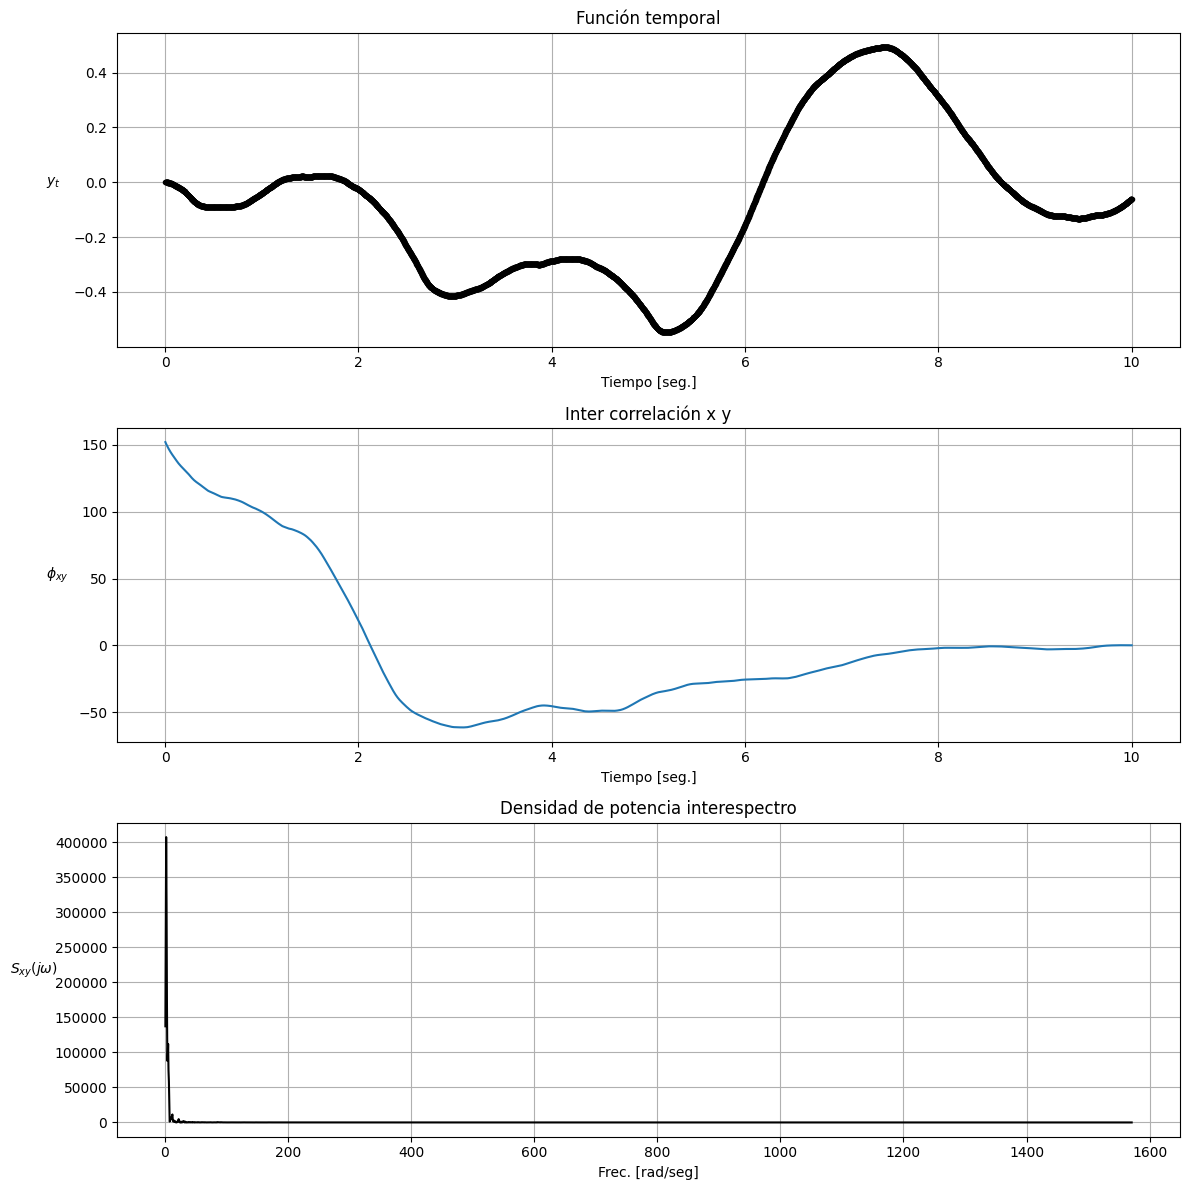

In [159]:
# Ingreso al sistema lineal discreto
y = np.zeros_like(x)
Orn = len(den_d)
for n in range(Orn-1, len(x)):
    y[n] = np.dot(num_d[:Orn], x[n-Orn+1:n+1][::-1]) - np.dot(den_d[1:Orn], y[n-Orn+1:n][::-1])

# Correlación cruzada xy
fixyM = signal.correlate(x, y, mode='full')

# Cálculo del interespectro
Sxy = fft.fft(fixyM)

# Gráficos de interespectro
with plt.style.context('ieee'):
  plt.figure(3, figsize=(12, 12), dpi=100)
plt.subplot(3, 1, 1)
plt.grid(True)
plt.plot(t, y, '.-k')
plt.title('Función temporal')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('$y_t$', rotation=0, labelpad=15)

plt.subplot(3, 1, 2)
plt.grid(True)
plt.plot(t, fixyM[N-1:2*N-1])
plt.title('Inter correlación x y')
plt.xlabel('Tiempo [seg.]')
plt.ylabel('$\phi_{xy}$', rotation=0, labelpad=15)

plt.subplot(3, 1, 3)
plt.grid(True)
plt.plot(w0[:M1//2], np.abs(Sxy[:M1//2]), 'k')
plt.title('Densidad de potencia interespectro')
plt.xlabel('Frec. [rad/seg]')
plt.ylabel('$S_{xy}(j\omega)$', rotation=0, labelpad=15)
plt.tight_layout()
plt.show()

## Cálculo de los valores de la función de transferencia

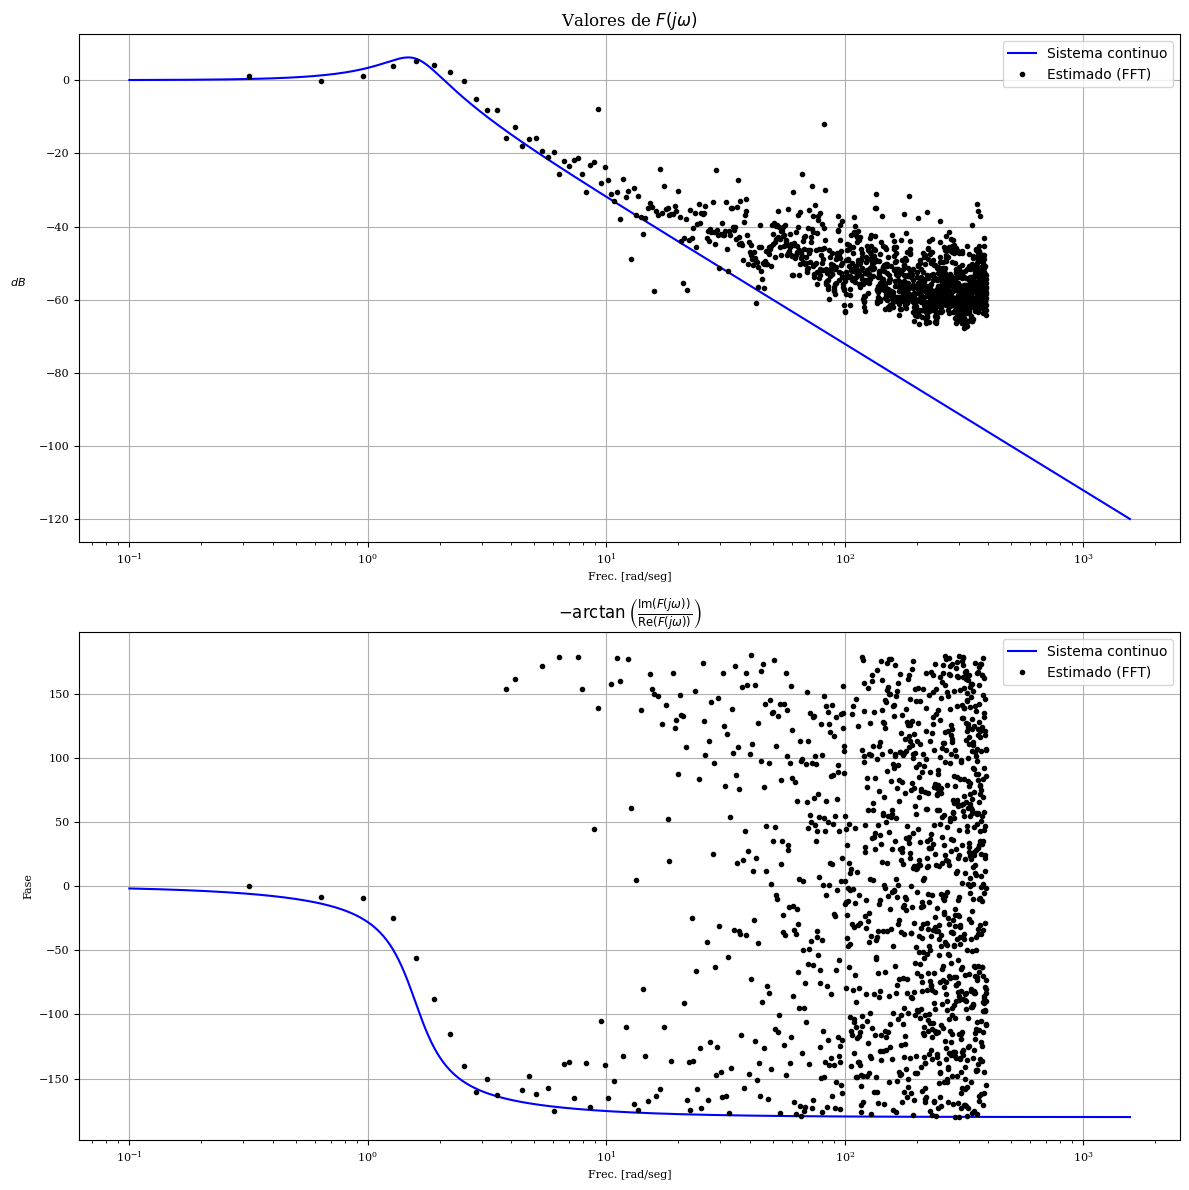

In [160]:
F_jw = Sxy / Sx # Cálculo de la función de transferencia estimada
# Respuesta en frecuencia del sistema continuo
w = np.logspace(-1, np.log10(fmax * 2 * np.pi), 1000)
omega, mag_db, phase  = signal.bode(sys_c, w)
# mag_db = 20 * np.log10(mag)

# Gráficos de magnitud y fase


# Usando FFT de las correlaciones completas
SxyM = fft.fft(fixyM)
SxM = fft.fft(fixxM)
SxM = np.pad(SxM, (0, len(SxyM) - len(SxM)), 'constant') # Pad with zeros to match length
F_jwM = SxyM / SxM

# Gráficos con FFT

with plt.style.context('ieee'):
# with plt.style.context('no-latex','science'):
# with plt.style.context('dark_background'):
  fig, axs = plt.subplots(2, 1, figsize=(12, 12), dpi=100) # Changed to 2 rows, 1 column
# subplot(2, 1, 1)
axs[0].semilogx(omega, mag_db, 'b', label='Sistema continuo')
axs[0].semilogx(w0[:M1//4]/2, 20 * np.log10(np.abs(F_jwM[:M1//4])), '.k', label='Estimado (FFT)')
axs[0].set_title('Valores de $F(j\omega)$')
axs[0].set_xlabel('Frec. [rad/seg]')
axs[0].set_ylabel('$dB$', rotation=0, labelpad=15)
axs[0].legend()
axs[0].grid(True)
# plt.axis([1e-1, 1e2, -50, 20])
#subplot(2, 1, 2)
axs[1].semilogx(omega, phase, 'b', label='Sistema continuo')
axs[1].semilogx(w0[:M1//4]/2, -180 * np.angle(F_jwM[:M1//4]) / np.pi, '.k', label='Estimado (FFT)')
# # plt.title('$-\arctan({\frac{Im(F(j\omega))}{Re(F(j\omega))}})$')
axs[1].set_title(r"$-\arctan\left(\frac{\mathrm{Im}(F(j\omega))}{\mathrm{Re}(F(j\omega))}\right)$")  # Corrected LaTeX
axs[1].set_xlabel('Frec. [rad/seg]')
axs[1].set_ylabel('Fase')
axs[1].legend()
axs[1].grid(True)
# # plt.axis([1e-1, 1e2, -270, 0])
plt.tight_layout()
plt.show()